In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv("../data/data_csv.csv")

In [3]:
df["Year"] = pd.DatetimeIndex(df['Date']).year
df["Month"] = pd.DatetimeIndex(df['Date']).month
start_y = 2000
end_y = 2018

df_new = df[df.Year>=start_y].reset_index(drop=True)
df_new = df_new.drop("Date", axis=1)

In [4]:
vif = pd.DataFrame()
df_vif = df_new
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)
print("\nIf VIF value is higher than 10, it is usually considered having high correlation with other independent variables.")

                features    vif_Factor
0                  SP500  30554.880871
1               Dividend  54192.804078
2               Earnings   6379.438636
3   Consumer Price Index   8168.074694
4     Long Interest Rate    108.567108
5             Real Price  46656.431890
6          Real Dividend  56584.761389
7          Real Earnings   5764.622216
8                   PE10   3765.205354
9                   Year   9182.814846
10                 Month      4.604038

If VIF value is higher than 10, it is usually considered having high correlation with other independent variables.


### To calculate real returns we use the formula:
return[t] = return[t-1] * (((Real Price[t] - Real Price[t-1]) / Real Price[t-1])) + 1) + (Real Dividend[t-1]/RealPrice[t-1]) * (return[t-1]/12)

In [5]:
def calculate_real_return(idx, old_idx, df_new_s):
    invested_returns = math.log(df_new_s["Real Price"].values[idx]) - math.log(df_new_s["Real Price"].values[old_idx])

    return invested_returns

In [6]:
previous_real_returns = []
previous_real_returns.append(0) # initial value

for y in range(len(df_new)-1):
    real_return = calculate_real_return(y+1, y, df_new) 
    previous_real_returns.append(real_return)

In [7]:
return_val = []
month = 1 # january
i = 0
month_count = []

for idx, row in df_new.iterrows():
    return_val.append(previous_real_returns[idx])
    if row.Month == month:
        month_count.append(i)
    else:
        month += 1
        i += 1
        month_count.append(i)

In [8]:
df_new["Return"] = return_val
df_new["InvestedMonths"] = month_count

(array([ 7., 16., 30., 63., 30., 15., 24., 19.,  8.,  4.]),
 array([ 889.28 , 1070.365, 1251.45 , 1432.535, 1613.62 , 1794.705,
        1975.79 , 2156.875, 2337.96 , 2519.045, 2700.13 ]),
 <a list of 10 Patch objects>)

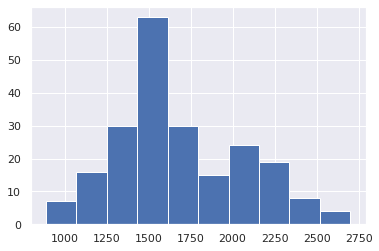

In [9]:
plt.hist(df_new["Real Price"])

(array([22., 21., 22., 21., 22., 21., 22., 21., 22., 22.]),
 array([  0. ,  21.5,  43. ,  64.5,  86. , 107.5, 129. , 150.5, 172. ,
        193.5, 215. ]),
 <a list of 10 Patch objects>)

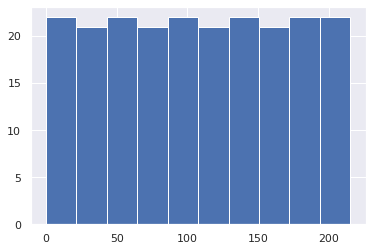

In [10]:
plt.hist(df_new["InvestedMonths"])

(array([20., 36., 55., 45.,  9.,  8., 21., 11.,  7.,  4.]),
 array([ 757.13 ,  947.851, 1138.572, 1329.293, 1520.014, 1710.735,
        1901.456, 2092.177, 2282.898, 2473.619, 2664.34 ]),
 <a list of 10 Patch objects>)

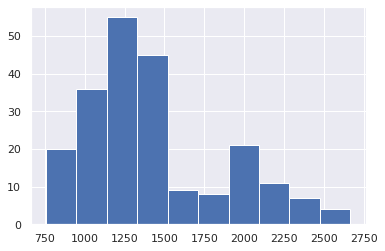

In [11]:
plt.hist(df_new["SP500"])

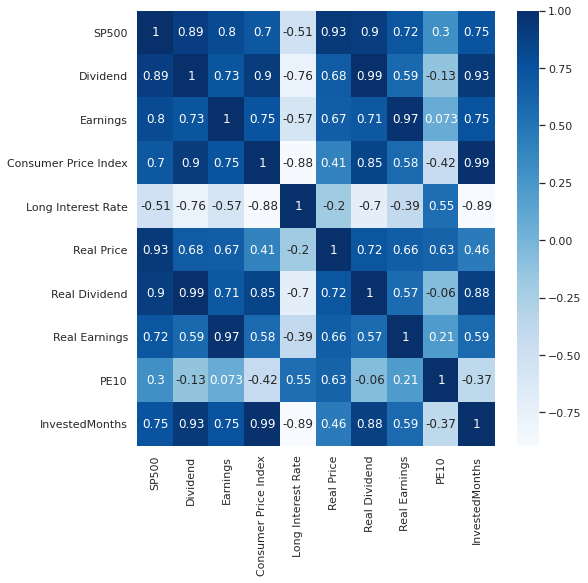

select those independent variables with high correlation with dependent variable


In [12]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_new.drop(["Return", "Year", "Month"], axis=1).corr(), annot=True, cmap=plt.cm.Blues)
plt.show()

print("select those independent variables with high correlation with dependent variable")

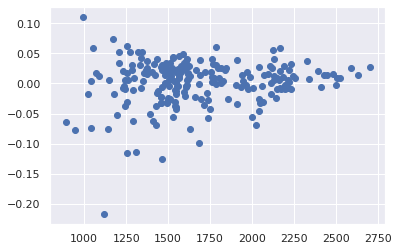

In [13]:
plt.scatter(df_new["Real Price"], df_new["Return"])

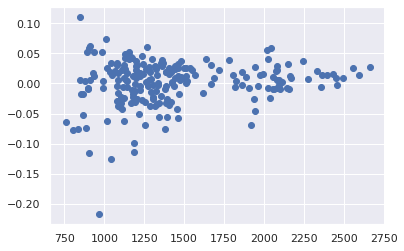

In [14]:
plt.scatter(df_new["SP500"], df_new["Return"])

Text(0, 0.5, 'Log Return')

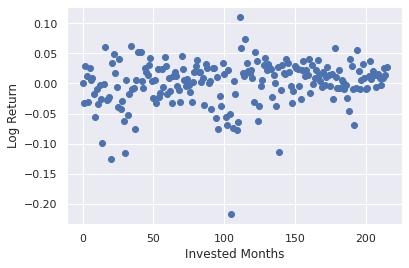

In [15]:
plt.scatter(df_new["InvestedMonths"], df_new["Return"])
plt.xlabel("Invested Months")
plt.ylabel("Log Return")

Text(0, 0.5, 'Log Return')

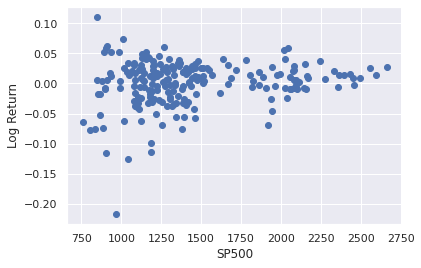

In [16]:
plt.scatter(df_new["SP500"], df_new["Return"])
plt.xlabel("SP500")
plt.ylabel("Log Return")

### Binary Classification

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

binary_results = []
for idx, row in df_new.iterrows():
    if row["Return"] > 0:
        binary_results.append(1)
    else:
        binary_results.append(0)
df_new["Class"] = binary_results

X = df_new[["SP500"]]
y = df_new[["Class"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

clf = LogisticRegression(random_state=0).fit(X_train, y_train.values.ravel())

y_pred = clf.predict(X_test)

f1_score(y_test, y_pred)

0.6133333333333334

In [18]:
vif = pd.DataFrame()
df_vif = df_new[["SP500", "Real Price"]]
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)
print("\nIf VIF value is higher than 10, it is usually considered having high correlation with other independent variables.")

     features  vif_Factor
0       SP500   74.213667
1  Real Price   74.213667

If VIF value is higher than 10, it is usually considered having high correlation with other independent variables.


In [19]:
def get_cv_scores(model, x, y):
    scores = cross_val_score(model, x, y, cv=10, scoring='r2')
    
    print(f'CV Mean: {np.mean(scores):.4f}')
    print(f'STD: {np.std(scores):.4f}')

In [20]:
def results(y_t, y_p):
    print(f'Mean squared error: {mean_squared_error(y_t, y_p):.4f}')
    # The coefficient of determination: 1 is perfect prediction
    print(f'Coefficient of determination: {r2_score(y_t, y_p):.4f}')

### Model 1: =  Return ~ SP500

In [21]:
X = df_new[["SP500"]]
y = df_new[["Return"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: -0.0353
STD: 0.1241
Mean squared error: 0.0010
Coefficient of determination: -0.0924


### Model 2: Return ~ InvestedMonths

In [22]:
X = df_new[["InvestedMonths"]]
y = df_new[["Return"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: -0.0531
STD: 0.1694
Mean squared error: 0.0009
Coefficient of determination: -0.0218


### Model 3: Return ~ SP500+RealPrice

In [23]:
X = df_new[["SP500", "Real Price"]]
y = df_new[["Return"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: -0.0572
STD: 0.1397
Mean squared error: 0.0010
Coefficient of determination: -0.0883


### Model 4: Return ~ All features

In [24]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

lr = LinearRegression().fit(X_train, y_train)

print("**** Results ****")
get_cv_scores(lr, X_train, y_train)

y_pred = lr.predict(X_test)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.4660
STD: 0.2272
Mean squared error: 0.0005
Coefficient of determination: 0.3860


#### From results above we could see that feature "Invested Years" doesn't improve our model so we could exclude it in future analysis.

## Using PCA to transform features

In [25]:
def transform_features(num_components, X_tr, X_te):
    scaler = MinMaxScaler()
    X_train_minmax = scaler.fit_transform(X_tr)
    X_test_minmax = scaler.transform(X_te)
    
    pca = PCA(n_components=num_components)
    X_train_pca = pca.fit_transform(X_train_minmax)
    X_test_pca = pca.transform(X_test_minmax)
    return pca, X_train_pca, X_test_pca

In [26]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

pca, X_train_pca, X_test_pca = transform_features(0.99, X_train, X_test)

lr = LinearRegression().fit(X_train_pca, y_train)
print("**** Results ****")
get_cv_scores(lr, X_train_pca, y_train)

y_pred = lr.predict(X_test_pca)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.4834
STD: 0.1263
Mean squared error: 0.0004
Coefficient of determination: 0.5757


In [27]:
X_train_sm = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     31.67
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           1.14e-24
Time:                        18:04:26   Log-Likelihood:                 358.30
No. Observations:                 162   AIC:                            -702.6
Df Residuals:                     155   BIC:                            -681.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.361      0.718      -0.003       0.005
x1             0.0140      0.003      4.983      0.000       0.008       0.020
x2            -0.0553      0.004    -12.536      0.000      -0.064      -0.047
x3             0.0003      0.006      0.050      0.960      -0.012       0.013
x4            -0.0114      0.007     -1.636      0.104      -0.025       0.002
x5            -0.0049      0.009     -0.521      0.603      -0.024       0.014
x6            -0.0495      0.022     -2.248      0.026      -0.093      -0.006
==============================================================================
Omnibus:                       86.947   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              803.769
Skew:                          -1.709   Prob(JB):                    2.91e-175
Kurtosis:                      13.363   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

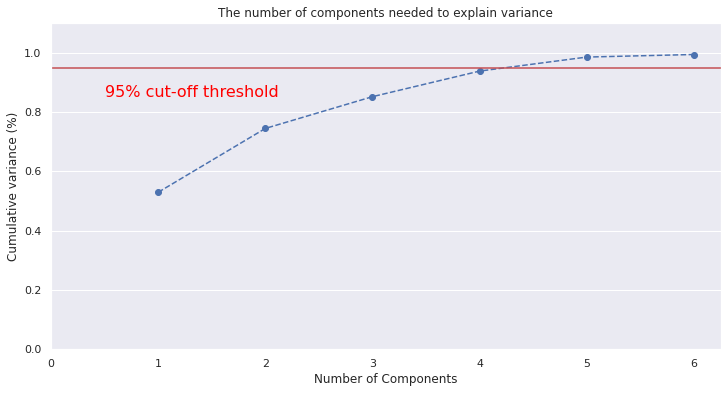

In [28]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
end_d = 7
xi = np.arange(1, end_d, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, end_d, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### From the plot above we could see that number of components is between 3 and 4.

### Model 5: Return ~ PCA  with 3 components

In [29]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# X_train_months = X_train["InvestedMonths"]
# X_test_months = X_test["InvestedMonths"]

# X_train = X_train.drop("InvestedMonths", axis=1)
# X_test = X_test.drop("InvestedMonths", axis=1)

pca, X_train_pca, X_test_pca = transform_features(4, X_train, X_test) # try with 3 components

lr = LinearRegression().fit(X_train_pca, y_train)
print("**** Results ****")
get_cv_scores(lr, X_train_pca, y_train)

y_pred = lr.predict(X_test_pca)
results(y_test, y_pred)

**** Results ****
CV Mean: 0.4983
STD: 0.0939
Mean squared error: 0.0004
Coefficient of determination: 0.5269


In [30]:
X_train_sm = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     45.21
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           3.22e-25
Time:                        18:04:27   Log-Likelihood:                 355.57
No. Observations:                 162   AIC:                            -701.1
Df Residuals:                     157   BIC:                            -685.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.357      0.721      -0.003       0.005
x1             0.0140      0.003      4.931      0.000       0.008       0.020
x2            -0.0553      0.004    -12.406      0.000      -0.064      -0.047
x3             0.0003      0.006      0.049      0.961      -0.012       0.013
x4            -0.0114      0.007     -1.619      0.107      -0.025       0.003
==============================================================================
Omnibus:                       97.930   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1049.791
Skew:                          -1.948   Prob(JB):                    1.10e-228
Kurtosis:                      14.847   Cond. No.                         3.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Return')

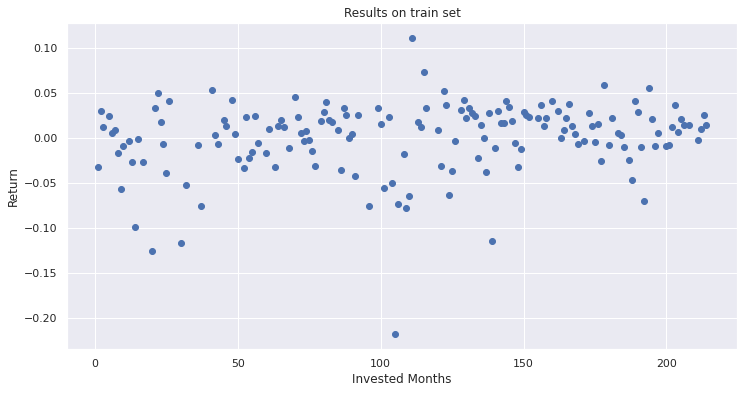

In [31]:
plt.scatter(list(X_train["InvestedMonths"]), y_train)
plt.title("Results on train set")
plt.xlabel("Invested Months")
plt.ylabel("Return")

Text(0, 0.5, 'Return')

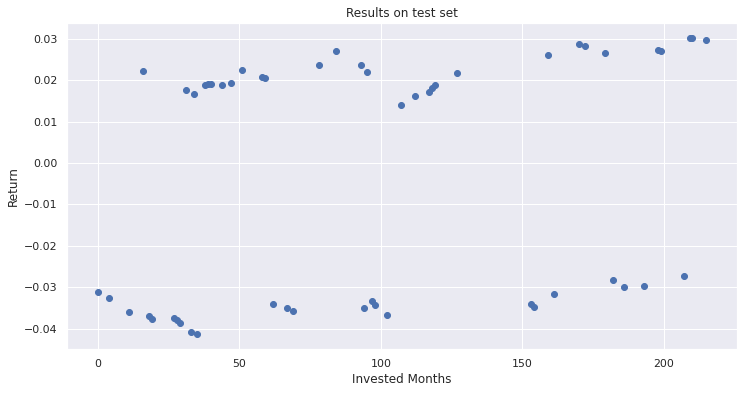

In [32]:
plt.scatter(list(X_test["InvestedMonths"]), y_pred.tolist())
plt.title("Results on test set")
plt.xlabel("Invested Months")
plt.ylabel("Return")